In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import timm

# List available ShuffleNet models
available_models = timm.list_models('*shufflenet*')
print("Available ShuffleNet Models:", available_models)


Available ShuffleNet Models: []


In [ ]:
!pip install timm==0.4.12


In [ ]:
import torch
import torchvision.models as models

# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ShuffleNetV2 from torchvision
model = models.shufflenet_v2_x1_0(weights='IMAGENET1K_V1')  # using the correct weights

# Adjust the classifier layer to match the number of classes
num_classes = 8
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Move the model to the specified device (GPU or CPU)
model = model.to(device)

# Now you can proceed with training the model


In [ ]:
# Root directory (Mounted on Google Colab)
base_path = "/content/drive/MyDrive/Guava"

# Subsets
train_dir = f"{base_path}/train"
val_dir   = f"{base_path}/val"
test_dir  = f"{base_path}/test"


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Training ShuffleNet V2 with EarlyStopping on Guava Dataset
Epoch 1/50 - Loss: 0.4340 - Val Acc: 88.20%
Epoch 2/50 - Loss: 0.2149 - Val Acc: 92.99%
Epoch 3/50 - Loss: 0.1544 - Val Acc: 90.85%
Epoch 4/50 - Loss: 0.1145 - Val Acc: 92.64%
Epoch 5/50 - Loss: 0.0938 - Val Acc: 92.64%
Epoch 6/50 - Loss: 0.0896 - Val Acc: 92.47%
Epoch 7/50 - Loss: 0.0721 - Val Acc: 93.33%
Epoch 8/50 - Loss: 0.0620 - Val Acc: 94.35%
Epoch 9/50 - Loss: 0.0563 - Val Acc: 94.35%
Epoch 10/50 - Loss: 0.0679 - Val Acc: 94.27%
Epoch 11/50 - Loss: 0.0351 - Val Acc: 92.99%
Epoch 12/50 - Loss: 0.0472 - Val Acc: 93.50%
Epoch 13/50 - Loss: 0.0553 - Val Acc: 92.47%
⏹️ Early stopping triggered after 13 epochs.


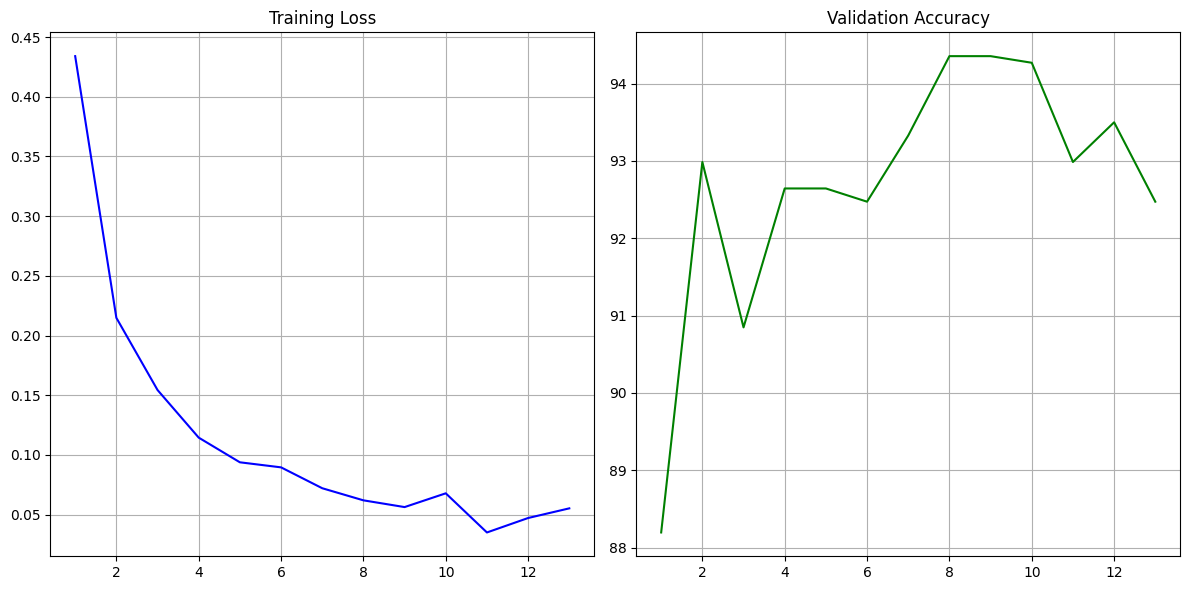

✅ Test Accuracy on Guava Dataset: 94.36%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
guava_root = "/content/drive/MyDrive/Guava"
train_path = os.path.join(guava_root, "train")
val_path = os.path.join(guava_root, "val")
test_path = os.path.join(guava_root, "test")

# Hyperparameters
batch_size = 32
num_epochs = 50
learning_rate = 0.001
num_classes = 4  # Algal, Fresh, Insect, Powder
patience = 5  # Early stopping patience

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Data loaders
train_loader = DataLoader(datasets.ImageFolder(train_path, transform=transform),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(val_path, transform=transform),
                        batch_size=batch_size, shuffle=False)
test_loader = DataLoader(datasets.ImageFolder(test_path, transform=transform),
                         batch_size=batch_size, shuffle=False)

# Initialize model
model = models.shufflenet_v2_x1_0(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function with EarlyStopping
def train_model(model, train_loader, val_loader):
    train_losses, val_accuracies = [], []
    best_val_acc = 0
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation step
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Val Acc: {val_acc:.2f}%")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping triggered after {epoch+1} epochs.")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    plot_training_curves(train_losses, val_accuracies)

# Plot training curves
def plot_training_curves(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Test function
def test_model(model, test_loader, name="Guava Dataset"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"✅ Test Accuracy on {name}: {100 * correct / total:.2f}%")

# Run training and testing
print("🚀 Training ShuffleNet V2 with EarlyStopping on Guava Dataset")
train_model(model, train_loader, val_loader)
test_model(model, test_loader)


Classification Reports & Confusion Matrix


=== Classification Report for Guava Dataset ===
              precision    recall  f1-score   support

       Algal       0.94      0.95      0.95       299
       Fresh       0.93      0.97      0.95       280
      Insect       0.97      0.89      0.93       298
      powder       0.94      0.96      0.95       294

    accuracy                           0.94      1171
   macro avg       0.94      0.94      0.94      1171
weighted avg       0.94      0.94      0.94      1171



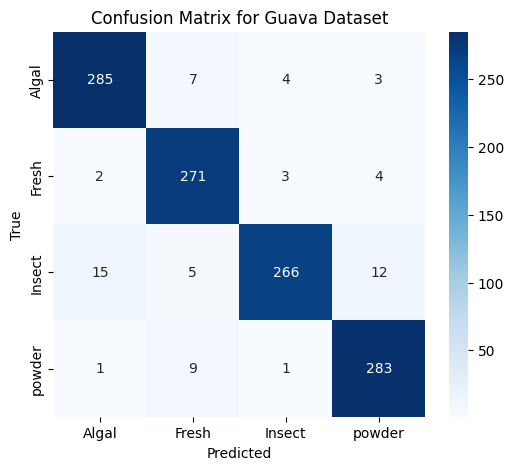

In [ ]:
# Cell: Guava Classification Report & Confusion Matrix

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make sure the model and device are already defined in earlier cells
# Example: model = ShuffleNetV2, device = torch.device("cuda" ...)

def print_classification_report(model, test_loader, name="Guava Dataset"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = model(imgs)
            _, preds = torch.max(outs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Class names from test loader
    class_names = test_loader.dataset.classes
    print(f"\n=== Classification Report for {name} ===")
    print(classification_report(y_true, y_pred,
                                target_names=class_names,
                                zero_division=0))

def plot_confusion_matrix(model, test_loader, name="Guava Dataset"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = model(imgs)
            _, preds = torch.max(outs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    class_names = test_loader.dataset.classes
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# === Apply to Guava Dataset ===
print_classification_report(model, test_loader, "Guava Dataset")
plot_confusion_matrix(model, test_loader, "Guava Dataset")

ROC & AUC curves

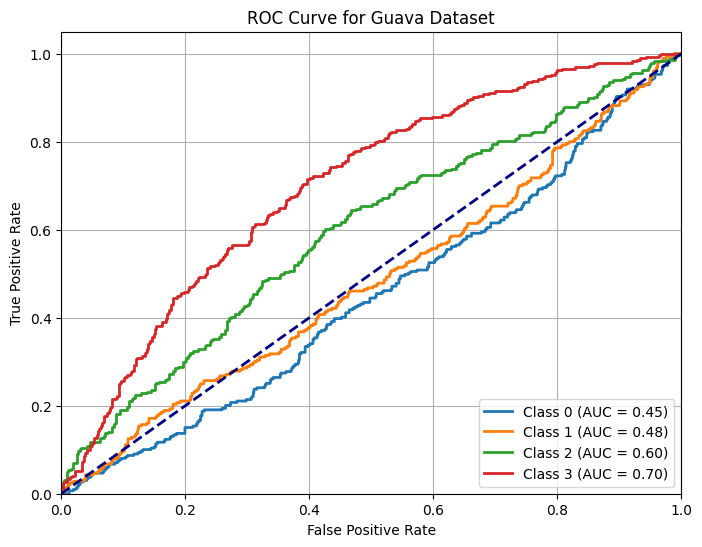

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, num_classes, title="ROC Curve"):
    y_true = label_binarize(y_true, classes=list(range(num_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Function to evaluate model and generate ROC & AUC
def test_model_for_roc_auc(model, test_loader, num_classes, name="Guava Dataset"):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    plot_roc_curve(all_labels, all_preds, num_classes, title=f"ROC Curve for {name}")

# === Apply to Guava Dataset ===
test_model_for_roc_auc(model, test_loader, num_classes=4, name="Guava Dataset")


PR Curves

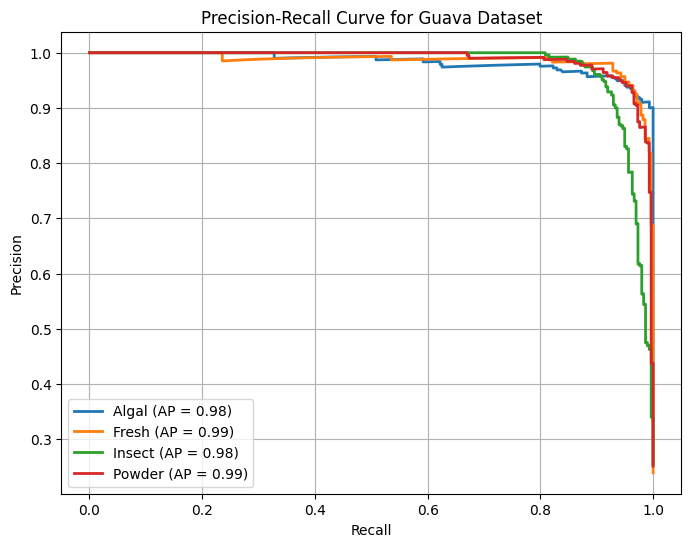

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Class names in order (ensure this matches your folder structure in ImageFolder)
class_names = ["Algal", "Fresh", "Insect", "Powder"]
num_classes = len(class_names)

# Plot PR curve
def plot_pr_curve(y_true, y_pred, num_classes, title="Precision-Recall Curve"):
    y_true = label_binarize(y_true, classes=list(range(num_classes)))

    precision = dict()
    recall = dict()
    avg_precision = dict()

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        avg_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2,
                 label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# Evaluate model for PR curve
def test_model_for_pr_curve(model, test_loader, num_classes, name="Guava Dataset"):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    plot_pr_curve(all_labels, all_probs, num_classes=num_classes,
                  title=f"Precision-Recall Curve for {name}")

# === Apply to Guava Dataset ===
test_model_for_pr_curve(model, test_loader, num_classes=4, name="Guava Dataset")


MCC Plot

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Loss: 0.4744 - Train MCC: 0.7973 - Val MCC: 0.8672
Epoch 2/10 - Loss: 0.2384 - Train MCC: 0.8954 - Val MCC: 0.8946
Epoch 3/10 - Loss: 0.1474 - Train MCC: 0.9372 - Val MCC: 0.9094
Epoch 4/10 - Loss: 0.1351 - Train MCC: 0.9430 - Val MCC: 0.9042
Epoch 5/10 - Loss: 0.1012 - Train MCC: 0.9528 - Val MCC: 0.9009
Epoch 6/10 - Loss: 0.0973 - Train MCC: 0.9610 - Val MCC: 0.9139
Epoch 7/10 - Loss: 0.0760 - Train MCC: 0.9658 - Val MCC: 0.9162
Epoch 8/10 - Loss: 0.0790 - Train MCC: 0.9638 - Val MCC: 0.9162
Epoch 9/10 - Loss: 0.0605 - Train MCC: 0.9718 - Val MCC: 0.8934
Epoch 10/10 - Loss: 0.0520 - Train MCC: 0.9752 - Val MCC: 0.9162


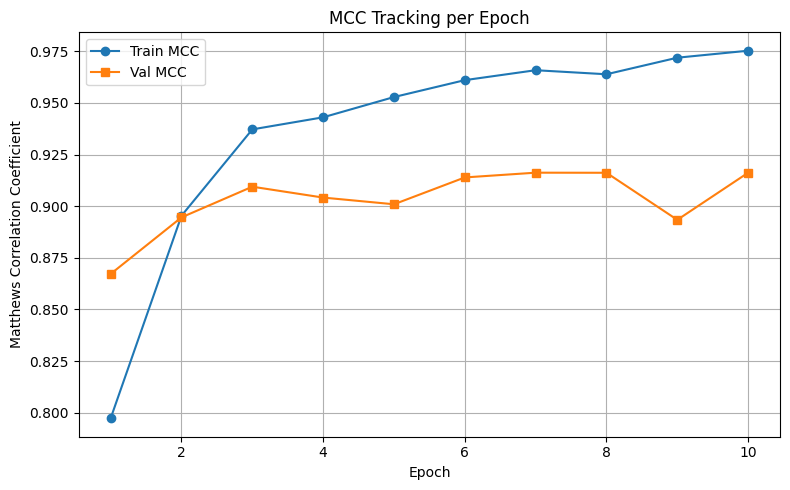

✅ Test Accuracy on Guava Dataset: 94.34%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import matthews_corrcoef
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Guava dataset paths
guava_path = "/content/drive/MyDrive/Guava/train"  # We'll split train into train/val/test
num_classes = 4  # Algal, Fresh, Insect, Powder

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset loading & splitting (from 'train' folder)
def load_dataset(path):
    ds = datasets.ImageFolder(path, transform=transform)
    total = len(ds)
    train_len = int(0.8 * total)
    val_len = int(0.1 * total)
    test_len = total - train_len - val_len
    train, val, test = random_split(ds, [train_len, val_len, test_len])
    return (DataLoader(train, batch_size=batch_size, shuffle=True),
            DataLoader(val, batch_size=batch_size, shuffle=False),
            DataLoader(test, batch_size=batch_size, shuffle=False))

# Plot MCC Curve
def plot_mcc_curve(train_mccs, val_mccs):
    epochs = range(1, len(train_mccs) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_mccs, label="Train MCC", marker='o')
    plt.plot(epochs, val_mccs, label="Val MCC", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Matthews Correlation Coefficient")
    plt.title("MCC Tracking per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Train with MCC tracking
def train_model_with_mcc(model, train_loader, val_loader):
    train_mccs, val_mccs = [], []
    for epoch in range(num_epochs):
        model.train()
        all_tr_y, all_tr_p = [], []
        running_loss = 0.0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outs = model(imgs)
            loss = criterion(outs, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = outs.argmax(1)
            all_tr_y.extend(lbls.cpu().numpy())
            all_tr_p.extend(preds.cpu().numpy())
        tr_mcc = matthews_corrcoef(all_tr_y, all_tr_p)
        train_mccs.append(tr_mcc)

        # Validation
        model.eval()
        all_val_y, all_val_p = [], []
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outs = model(imgs)
                preds = outs.argmax(1)
                all_val_y.extend(lbls.cpu().numpy())
                all_val_p.extend(preds.cpu().numpy())
        val_mcc = matthews_corrcoef(all_val_y, all_val_p)
        val_mccs.append(val_mcc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Loss: {running_loss/len(train_loader):.4f} - "
              f"Train MCC: {tr_mcc:.4f} - Val MCC: {val_mcc:.4f}")

    plot_mcc_curve(train_mccs, val_mccs)

# Test final model
def test_model(model, test_loader, name="Guava Dataset"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            preds = outs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    print(f"✅ Test Accuracy on {name}: {100 * correct / total:.2f}%")

# Load dataset
train_loader, val_loader, test_loader = load_dataset(guava_path)

# Initialize model
model = models.shufflenet_v2_x1_0(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# === Run training with MCC tracking and test evaluation ===
train_model_with_mcc(model, train_loader, val_loader)
test_model(model, test_loader, name="Guava Dataset")


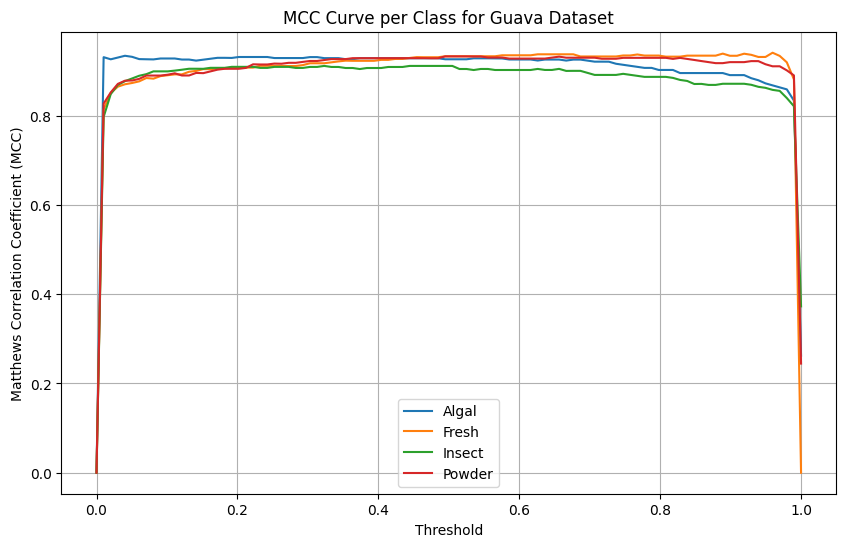

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import label_binarize

# Class names and number of classes
class_names = ["Algal", "Fresh", "Insect", "Powder"]
num_classes = len(class_names)

# Function to compute MCC across thresholds
def plot_mcc_curve(model, test_loader, name="Guava Dataset"):
    model.eval()
    y_true_all = []
    y_score_all = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            y_true_all.extend(labels.cpu().numpy())
            y_score_all.extend(probs.cpu().numpy())

    y_true_all = np.array(y_true_all)
    y_score_all = np.array(y_score_all)

    # MCC vs Threshold per class
    thresholds = np.linspace(0.0, 1.0, 100)
    plt.figure(figsize=(10, 6))

    for i in range(num_classes):
        mcc_values = []
        for thresh in thresholds:
            preds_bin = (y_score_all[:, i] >= thresh).astype(int)
            true_bin = (y_true_all == i).astype(int)
            mcc = matthews_corrcoef(true_bin, preds_bin)
            mcc_values.append(mcc)
        plt.plot(thresholds, mcc_values, label=f"{class_names[i]}")

    plt.title(f"MCC Curve per Class for {name}")
    plt.xlabel("Threshold")
    plt.ylabel("Matthews Correlation Coefficient (MCC)")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Apply MCC Plot on Guava Dataset ===
plot_mcc_curve(model, test_loader, name="Guava Dataset")


F1 Score Vs MCC Plot*****************


📊 Debug Info: Class-wise True & Predicted Count
Class 'Algal': True=242, Predicted=229
Class 'Fresh': True=222, Predicted=221
Class 'Insect': True=227, Predicted=246
Class 'Powder': True=245, Predicted=240


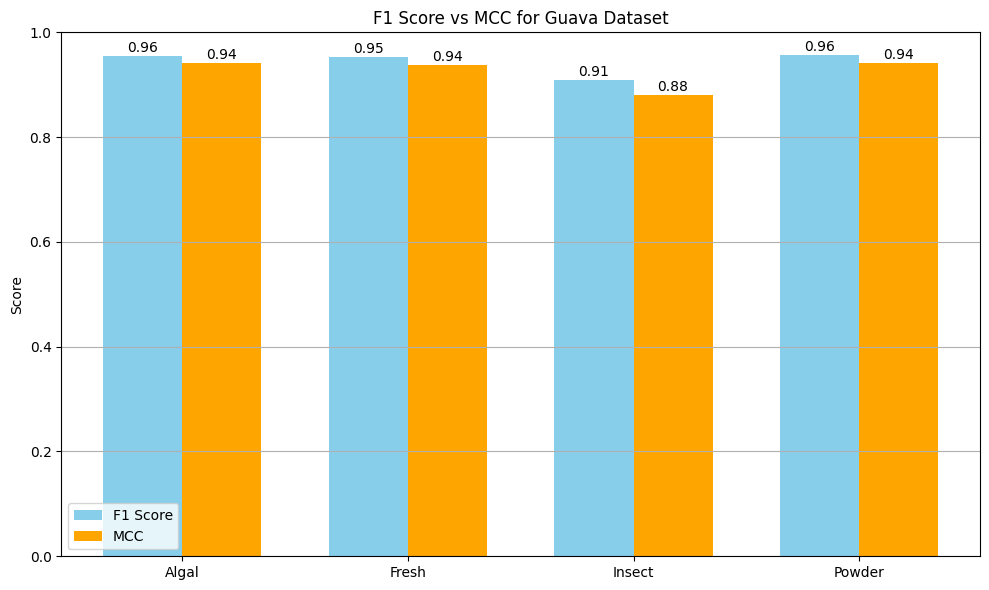

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, matthews_corrcoef
from collections import Counter

# Class names for Guava dataset
class_names = ["Algal", "Fresh", "Insect", "Powder"]
num_classes = len(class_names)

def plot_f1_mcc_barplot(model, test_loader, name="Guava Dataset"):
    model.eval()
    y_true_all = []
    y_pred_all = []

    # Collect predictions and labels
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true_all.extend(labels.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    f1_scores = []
    mcc_scores = []

    print("\n📊 Debug Info: Class-wise True & Predicted Count")
    for i in range(num_classes):
        y_true_bin = (y_true_all == i).astype(int)
        y_pred_bin = (y_pred_all == i).astype(int)

        print(f"Class '{class_names[i]}': True={np.sum(y_true_bin)}, Predicted={np.sum(y_pred_bin)}")

        f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
        mcc = matthews_corrcoef(y_true_bin, y_pred_bin)

        f1_scores.append(f1)
        mcc_scores.append(mcc)

    # Bar plot setup
    x = np.arange(num_classes)
    width = 0.35

    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(x - width/2, f1_scores, width, label='F1 Score', color='skyblue')
    bars2 = plt.bar(x + width/2, mcc_scores, width, label='MCC', color='orange')

    # Add value labels (including zeros)
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

    for bar in bars2:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

    plt.xticks(x, class_names)
    plt.ylabel('Score')
    plt.title(f"F1 Score vs MCC for {name}")
    plt.legend()
    plt.grid(axis='y')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

# === Run the updated plot ===
plot_f1_mcc_barplot(model, test_loader, name="Guava Dataset")


Grad Cam

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


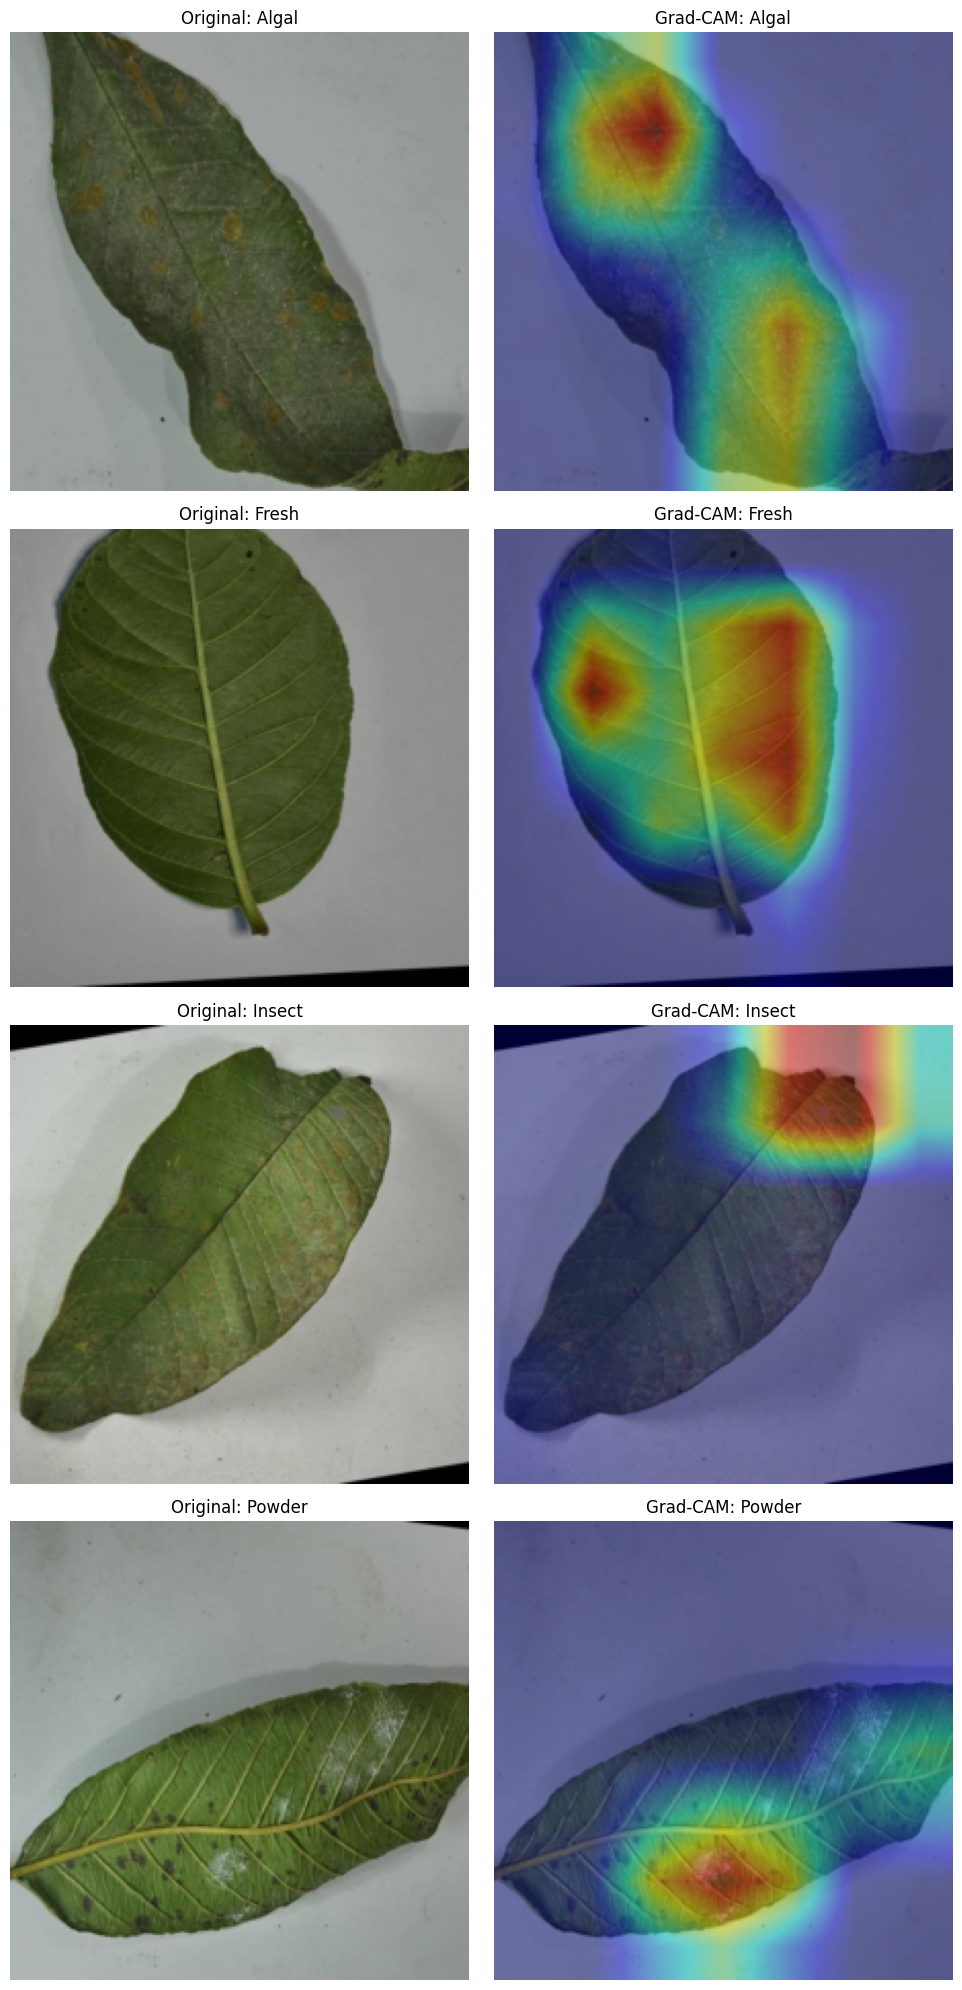

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1) Grad-CAM Helper Class ===
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.grad = None
        self.activ = None
        target_layer.register_forward_hook(self._save_activ)
        target_layer.register_backward_hook(self._save_grad)

    def _save_activ(self, module, input, output):
        self.activ = output

    def _save_grad(self, module, grad_input, grad_output):
        self.grad = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[0, class_idx]
        loss.backward()

        grads = self.grad[0]
        activs = self.activ[0]
        weights = grads.mean(dim=(1, 2))
        cam = (weights[:, None, None] * activs).sum(dim=0)
        cam = F.relu(cam)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.cpu().detach().numpy()

# === 2) Unnormalize Helper ===
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def unnormalize(tensor):
    img = tensor.cpu().numpy().transpose(1,2,0)
    img = img * std + mean
    return np.clip(img, 0, 1)

# === 3) Overlay Heatmap Helper ===
def overlay_heatmap(img_tensor, heatmap):
    img = unnormalize(img_tensor)
    img_uint8 = (img * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize((heatmap * 255).astype(np.uint8), (img_bgr.shape[1], img_bgr.shape[0]))
    hmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    return cv2.addWeighted(img_bgr, 0.6, hmap_color, 0.4, 0)

# === 4) Load Trained Model ===
# Assuming 'model' is your trained ShuffleNetV2 on the Guava dataset
model.to(device)

# === 5) Set up Grad-CAM on the last conv layer of ShuffleNetV2 ===
gradcam = GradCAM(model, model.conv5)

# === 6) Define class names and get 1 sample per class ===
guava_classes = ["Algal", "Fresh", "Insect", "Powder"]
samples = {}

for imgs, labels in test_loader:
    for img, lbl in zip(imgs, labels):
        lbl = lbl.item()
        if lbl not in samples:
            samples[lbl] = img.unsqueeze(0).to(device)
        if len(samples) == len(guava_classes):
            break
    if len(samples) == len(guava_classes):
        break

# === 7) Plot Original and Grad-CAM Overlay ===
n = len(guava_classes)
fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))
for i, class_idx in enumerate(sorted(samples.keys())):
    input_tensor = samples[class_idx]
    heatmap = gradcam(input_tensor, class_idx=class_idx)
    overlay = overlay_heatmap(input_tensor[0], heatmap)

    # Original image
    axes[i, 0].imshow(unnormalize(input_tensor[0]))
    axes[i, 0].set_title(f"Original: {guava_classes[class_idx]}")
    axes[i, 0].axis('off')

    # Grad-CAM overlay
    axes[i, 1].imshow(overlay[:, :, ::-1])  # Convert BGR to RGB
    axes[i, 1].set_title(f"Grad-CAM: {guava_classes[class_idx]}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
